# Preprocessing Methods Comparative Analysis

This notebook implements a comprehensive analysis to determine the optimal preprocessing pipeline for cervical cancer cell classification. We will test all possible combinations of the three main preprocessing methods:

## Preprocessing Methods Under Analysis:
1. **PMD (Perona-Malik Diffusion)** - Edge-preserving anisotropic diffusion
2. **Enhanced CLAHE** - Contrast-Limited Adaptive Histogram Equalization
3. **NLM (Non-Local Means)** - Advanced denoising algorithm

## Testing Strategy:
### Single Methods (3 combinations):
- PMD only
- Enhanced CLAHE only
- NLM only

### Two Methods Combined (3 combinations):
- PMD + Enhanced CLAHE
- PMD + NLM
- Enhanced CLAHE + NLM

### All Three Methods in Different Orders (6 combinations):
- PMD → Enhanced CLAHE → NLM
- PMD → NLM → Enhanced CLAHE
- Enhanced CLAHE → PMD → NLM
- Enhanced CLAHE → NLM → PMD
- NLM → PMD → Enhanced CLAHE
- NLM → Enhanced CLAHE → PMD

**Total: 12 different preprocessing combinations**

We will test these on 2 sample images from each of the 5 cell categories (10 images total) and evaluate the results visually and quantitatively.

## Import Libraries and Setup Configuration

In [2]:
# Essential Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import time
import warnings
from itertools import permutations
import seaborn as sns
from skimage import measure, filters
from skimage.metrics import structural_similarity as ssim
warnings.filterwarnings('ignore')

# Configuration
BASE_DIR = Path(r"c:\Meet\Projects\Project_8_Phoenix_Cervical Cancer Image Classification\Project-Phoenix")
RAW_DATASET_PATH = BASE_DIR / "Dataset" / "Raw Dataset" / "SipakMed Dataset"
OUTPUT_DIR = BASE_DIR / "Image Preprocessing" / "Comparative Analysis Results"

# Create output directory
OUTPUT_DIR.mkdir(exist_ok=True)

# Target size for processed images
TARGET_SIZE = (256, 256)

# Dataset Class Labels
CLASS_NAMES = [
    'im_Dyskeratotic',
    'im_Koilocytotic', 
    'im_Metaplastic',
    'im_Parabasal',
    'im_Superficial-Intermediate'
]

print("Configuration loaded successfully")
print(f"Input Dataset Path: {RAW_DATASET_PATH}")
print(f"Output Directory: {OUTPUT_DIR}")
print(f"Number of Classes: {len(CLASS_NAMES)}")
print(f"Target Image Size: {TARGET_SIZE}")

Configuration loaded successfully
Input Dataset Path: c:\Meet\Projects\Project_8_Phoenix_Cervical Cancer Image Classification\Project-Phoenix\Dataset\Raw Dataset\SipakMed Dataset
Output Directory: c:\Meet\Projects\Project_8_Phoenix_Cervical Cancer Image Classification\Project-Phoenix\Image Preprocessing\Comparative Analysis Results
Number of Classes: 5
Target Image Size: (256, 256)


## Define Individual Preprocessing Functions

In [3]:
def apply_pmd_filter(image, num_iterations=5, kappa=30, gamma=0.1):
    """
    Apply Perona-Malik Diffusion filter for edge-preserving smoothing.
    Using bilateral filtering as an approximation to PMD.
    """
    try:
        # Convert to float for processing precision
        img_float = image.astype(np.float32) / 255.0
        
        # Apply bilateral filtering as PMD approximation
        filtered = cv2.bilateralFilter(img_float, d=7, sigmaColor=50, sigmaSpace=50)
        
        # Convert back to uint8 format
        return (filtered * 255).astype(np.uint8)
        
    except Exception as e:
        print(f"PMD filtering failed: {e}")
        return image

def apply_enhanced_clahe(image, clip_limit=1.2, tile_grid_size=(6, 6), 
                        preserve_colors=True, gentle_blend=True, blend_factor=0.8):
    """
    Apply Enhanced Contrast-Limited Adaptive Histogram Equalization.
    """
    try:
        if image is None:
            return None
            
        # Analyze image characteristics for adaptive parameter adjustment
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image
            
        mean_intensity = np.mean(gray)
        std_intensity = np.std(gray)
        
        # Adaptive clip limit based on image contrast characteristics
        if std_intensity < 20:  # Low contrast images
            adaptive_clip = min(clip_limit * 1.3, 2.0)
        elif std_intensity > 45:  # High contrast images
            adaptive_clip = max(clip_limit * 0.7, 0.8)
        else:
            adaptive_clip = clip_limit
            
        # Brightness-based adjustment
        if mean_intensity < 80:  # Dark images
            adaptive_clip *= 1.1
        elif mean_intensity > 170:  # Bright images
            adaptive_clip *= 0.9
        
        if len(image.shape) == 3 and preserve_colors:
            # Apply CLAHE to L-channel in LAB color space for color preservation
            lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
            l_channel = lab[:, :, 0]
            
            clahe = cv2.createCLAHE(clipLimit=adaptive_clip, tileGridSize=tile_grid_size)
            enhanced_l = clahe.apply(l_channel)
            
            # Apply gentle blending to prevent harsh transitions
            if gentle_blend:
                enhanced_l = cv2.addWeighted(enhanced_l, blend_factor, l_channel, 1-blend_factor, 0)
            
            # Reconstruct the enhanced image
            lab[:, :, 0] = enhanced_l
            enhanced_image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
            
        elif len(image.shape) == 3:
            # Apply CLAHE to each channel independently
            clahe = cv2.createCLAHE(clipLimit=adaptive_clip, tileGridSize=tile_grid_size)
            channels = cv2.split(image)
            enhanced_channels = []
            
            for channel in channels:
                enhanced_channel = clahe.apply(channel)
                if gentle_blend:
                    enhanced_channel = cv2.addWeighted(enhanced_channel, blend_factor, channel, 1-blend_factor, 0)
                enhanced_channels.append(enhanced_channel)
            
            enhanced_image = cv2.merge(enhanced_channels)
        else:
            # Grayscale image processing
            clahe = cv2.createCLAHE(clipLimit=adaptive_clip, tileGridSize=tile_grid_size)
            enhanced_image = clahe.apply(image)
            
            if gentle_blend:
                enhanced_image = cv2.addWeighted(enhanced_image, blend_factor, image, 1-blend_factor, 0)
        
        return enhanced_image
        
    except Exception as e:
        print(f"Enhanced CLAHE processing failed: {e}")
        return image

def apply_nlm_denoising(image, h=10, template_window_size=7, search_window_size=21):
    """
    Apply Non-Local Means denoising for advanced noise reduction.
    """
    try:
        if image is None:
            return None
        
        # Apply NLM denoising based on image type
        if len(image.shape) == 3:
            # Color image processing
            denoised_image = cv2.fastNlMeansDenoisingColored(
                image, None, h, h, template_window_size, search_window_size
            )
        else:
            # Grayscale image processing
            denoised_image = cv2.fastNlMeansDenoising(
                image, None, h, template_window_size, search_window_size
            )
        
        return denoised_image
        
    except Exception as e:
        print(f"NLM denoising failed: {e}")
        return image

print("Individual preprocessing functions defined successfully")

Individual preprocessing functions defined successfully


## Define Quality Assessment Metrics

In [4]:
def calculate_image_quality_metrics(original, processed):
    """
    Calculate various image quality metrics to assess preprocessing effectiveness.
    """
    metrics = {}
    
    try:
        # Convert to grayscale for some metrics
        if len(original.shape) == 3:
            original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
            processed_gray = cv2.cvtColor(processed, cv2.COLOR_BGR2GRAY)
        else:
            original_gray = original
            processed_gray = processed
        
        # 1. Structural Similarity Index (SSIM)
        metrics['SSIM'] = ssim(original_gray, processed_gray)
        
        # 2. Peak Signal-to-Noise Ratio (PSNR)
        mse = np.mean((original_gray.astype(float) - processed_gray.astype(float)) ** 2)
        if mse == 0:
            metrics['PSNR'] = float('inf')
        else:
            metrics['PSNR'] = 20 * np.log10(255.0 / np.sqrt(mse))
        
        # 3. Contrast Enhancement Ratio
        original_std = np.std(original_gray)
        processed_std = np.std(processed_gray)
        metrics['Contrast_Enhancement'] = processed_std / original_std if original_std != 0 else 1.0
        
        # 4. Edge Preservation Index
        original_edges = cv2.Canny(original_gray, 50, 150)
        processed_edges = cv2.Canny(processed_gray, 50, 150)
        edge_correlation = np.corrcoef(original_edges.flatten(), processed_edges.flatten())[0, 1]
        metrics['Edge_Preservation'] = edge_correlation if not np.isnan(edge_correlation) else 0.0
        
        # 5. Noise Reduction Estimate (inverse of total variation)
        def total_variation(img):
            return np.sum(np.abs(np.diff(img, axis=0))) + np.sum(np.abs(np.diff(img, axis=1)))
        
        original_tv = total_variation(original_gray)
        processed_tv = total_variation(processed_gray)
        metrics['Noise_Reduction'] = (original_tv - processed_tv) / original_tv if original_tv != 0 else 0.0
        
        # 6. Mean Brightness
        metrics['Mean_Brightness'] = np.mean(processed_gray)
        
        # 7. Dynamic Range
        metrics['Dynamic_Range'] = np.max(processed_gray) - np.min(processed_gray)
        
    except Exception as e:
        print(f"Error calculating metrics: {e}")
        # Return default metrics if calculation fails
        metrics = {
            'SSIM': 0.0,
            'PSNR': 0.0,
            'Contrast_Enhancement': 1.0,
            'Edge_Preservation': 0.0,
            'Noise_Reduction': 0.0,
            'Mean_Brightness': 128.0,
            'Dynamic_Range': 255.0
        }
    
    return metrics

print("Quality assessment metrics defined successfully")

Quality assessment metrics defined successfully


## Define Combination Testing Framework

In [5]:
# Define all preprocessing combinations to test
PREPROCESSING_COMBINATIONS = [
    # Single methods
    {'name': 'PMD_only', 'methods': ['PMD']},
    {'name': 'CLAHE_only', 'methods': ['CLAHE']},
    {'name': 'NLM_only', 'methods': ['NLM']},
    
    # Two methods combined
    {'name': 'PMD_CLAHE', 'methods': ['PMD', 'CLAHE']},
    {'name': 'PMD_NLM', 'methods': ['PMD', 'NLM']},
    {'name': 'CLAHE_NLM', 'methods': ['CLAHE', 'NLM']},
    
    # All three methods in different orders
    {'name': 'PMD_CLAHE_NLM', 'methods': ['PMD', 'CLAHE', 'NLM']},
    {'name': 'PMD_NLM_CLAHE', 'methods': ['PMD', 'NLM', 'CLAHE']},
    {'name': 'CLAHE_PMD_NLM', 'methods': ['CLAHE', 'PMD', 'NLM']},
    {'name': 'CLAHE_NLM_PMD', 'methods': ['CLAHE', 'NLM', 'PMD']},
    {'name': 'NLM_PMD_CLAHE', 'methods': ['NLM', 'PMD', 'CLAHE']},
    {'name': 'NLM_CLAHE_PMD', 'methods': ['NLM', 'CLAHE', 'PMD']}
]

def apply_preprocessing_combination(image, combination):
    """
    Apply a specific combination of preprocessing methods to an image.
    """
    processed_image = image.copy()
    
    for method in combination['methods']:
        if method == 'PMD':
            processed_image = apply_pmd_filter(processed_image)
        elif method == 'CLAHE':
            processed_image = apply_enhanced_clahe(processed_image)
        elif method == 'NLM':
            processed_image = apply_nlm_denoising(processed_image)
    
    return processed_image

print(f"Defined {len(PREPROCESSING_COMBINATIONS)} preprocessing combinations to test:")
for combo in PREPROCESSING_COMBINATIONS:
    print(f"  - {combo['name']}: {' → '.join(combo['methods'])}")

Defined 12 preprocessing combinations to test:
  - PMD_only: PMD
  - CLAHE_only: CLAHE
  - NLM_only: NLM
  - PMD_CLAHE: PMD → CLAHE
  - PMD_NLM: PMD → NLM
  - CLAHE_NLM: CLAHE → NLM
  - PMD_CLAHE_NLM: PMD → CLAHE → NLM
  - PMD_NLM_CLAHE: PMD → NLM → CLAHE
  - CLAHE_PMD_NLM: CLAHE → PMD → NLM
  - CLAHE_NLM_PMD: CLAHE → NLM → PMD
  - NLM_PMD_CLAHE: NLM → PMD → CLAHE
  - NLM_CLAHE_PMD: NLM → CLAHE → PMD


## Load Sample Images from Each Category

In [6]:
def load_sample_images(num_samples_per_class=2):
    """
    Load sample images from each cell category for testing.
    """
    sample_images = {}
    
    for class_name in CLASS_NAMES:
        class_path = RAW_DATASET_PATH / class_name / class_name
        
        if not class_path.exists():
            print(f"Warning: Path {class_path} does not exist")
            continue
        
        # Get all .bmp files in the directory
        image_files = list(class_path.glob('*.bmp'))
        
        if len(image_files) < num_samples_per_class:
            print(f"Warning: Only {len(image_files)} images found in {class_name}, using all available")
            selected_files = image_files
        else:
            # Select first few images for consistency
            selected_files = sorted(image_files)[:num_samples_per_class]
        
        sample_images[class_name] = []
        
        for img_file in selected_files:
            try:
                image = cv2.imread(str(img_file))
                if image is not None:
                    # Resize to target size for consistent processing
                    image_resized = cv2.resize(image, TARGET_SIZE, interpolation=cv2.INTER_LANCZOS4)
                    sample_images[class_name].append({
                        'image': image_resized,
                        'filename': img_file.name,
                        'path': str(img_file)
                    })
                    print(f"Loaded: {class_name}/{img_file.name}")
                else:
                    print(f"Failed to load: {img_file}")
            except Exception as e:
                print(f"Error loading {img_file}: {e}")
    
    return sample_images

# Load sample images
print("Loading sample images...")
sample_images = load_sample_images(num_samples_per_class=2)

# Display summary
total_images = sum(len(images) for images in sample_images.values())
print(f"\nLoaded {total_images} sample images:")
for class_name, images in sample_images.items():
    print(f"  {class_name}: {len(images)} images")

Loading sample images...
Loaded: im_Dyskeratotic/001.bmp
Loaded: im_Dyskeratotic/002.bmp
Loaded: im_Koilocytotic/001.bmp
Loaded: im_Koilocytotic/002.bmp
Loaded: im_Metaplastic/001.bmp
Loaded: im_Metaplastic/002.bmp
Loaded: im_Parabasal/001.bmp
Loaded: im_Parabasal/002.bmp
Loaded: im_Superficial-Intermediate/001.bmp
Loaded: im_Superficial-Intermediate/002.bmp

Loaded 10 sample images:
  im_Dyskeratotic: 2 images
  im_Koilocytotic: 2 images
  im_Metaplastic: 2 images
  im_Parabasal: 2 images
  im_Superficial-Intermediate: 2 images


## Run Comprehensive Preprocessing Analysis

In [7]:
def run_comprehensive_analysis():
    """
    Run all preprocessing combinations on all sample images and collect metrics.
    """
    results = []
    processed_images = {}  # Store processed images for visualization
    
    print("Starting comprehensive preprocessing analysis...")
    
    # Process each combination
    for combo_idx, combination in enumerate(tqdm(PREPROCESSING_COMBINATIONS, desc="Testing combinations")):
        print(f"\nTesting combination: {combination['name']}")
        
        processed_images[combination['name']] = {}
        
        # Process each class
        for class_name, images in sample_images.items():
            processed_images[combination['name']][class_name] = []
            
            # Process each image in the class
            for img_idx, img_data in enumerate(images):
                original_image = img_data['image']
                filename = img_data['filename']
                
                # Apply preprocessing combination
                start_time = time.time()
                processed_image = apply_preprocessing_combination(original_image, combination)
                processing_time = time.time() - start_time
                
                # Calculate quality metrics
                metrics = calculate_image_quality_metrics(original_image, processed_image)
                
                # Store results
                result = {
                    'combination': combination['name'],
                    'methods': ' → '.join(combination['methods']),
                    'class': class_name,
                    'filename': filename,
                    'processing_time': processing_time,
                    **metrics
                }
                results.append(result)
                
                # Store processed image for visualization
                processed_images[combination['name']][class_name].append({
                    'original': original_image,
                    'processed': processed_image,
                    'filename': filename
                })
    
    return results, processed_images

# Run the analysis
print("\n" + "="*60)
print("STARTING COMPREHENSIVE PREPROCESSING ANALYSIS")
print("="*60)

analysis_results, processed_images_data = run_comprehensive_analysis()

print(f"\nAnalysis completed! Processed {len(analysis_results)} image-combination pairs.")


STARTING COMPREHENSIVE PREPROCESSING ANALYSIS
Starting comprehensive preprocessing analysis...


Testing combinations:   0%|          | 0/12 [00:00<?, ?it/s]


Testing combination: PMD_only


Testing combinations:   8%|▊         | 1/12 [00:00<00:02,  5.41it/s]


Testing combination: CLAHE_only


Testing combinations:  17%|█▋        | 2/12 [00:00<00:02,  3.53it/s]


Testing combination: NLM_only


Testing combinations:  33%|███▎      | 4/12 [00:08<00:18,  2.33s/it]


Testing combination: PMD_CLAHE

Testing combination: PMD_NLM


Testing combinations:  42%|████▏     | 5/12 [00:16<00:29,  4.27s/it]


Testing combination: CLAHE_NLM


Testing combinations:  50%|█████     | 6/12 [00:23<00:32,  5.40s/it]


Testing combination: PMD_CLAHE_NLM


Testing combinations:  58%|█████▊    | 7/12 [00:31<00:30,  6.16s/it]


Testing combination: PMD_NLM_CLAHE


Testing combinations:  67%|██████▋   | 8/12 [00:39<00:26,  6.67s/it]


Testing combination: CLAHE_PMD_NLM


Testing combinations:  75%|███████▌  | 9/12 [00:47<00:20,  7.00s/it]


Testing combination: CLAHE_NLM_PMD


Testing combinations:  83%|████████▎ | 10/12 [00:54<00:14,  7.22s/it]


Testing combination: NLM_PMD_CLAHE


Testing combinations:  92%|█████████▏| 11/12 [01:02<00:07,  7.36s/it]


Testing combination: NLM_CLAHE_PMD


Testing combinations: 100%|██████████| 12/12 [01:10<00:00,  5.84s/it]


Analysis completed! Processed 120 image-combination pairs.


## Load Cropped Individual Cell Images for Enhanced Analysis

The analysis above used complete slide images which contain multiple cells. For a more focused analysis on individual cell morphology, we'll now perform the same preprocessing analysis on individual cropped cells from the "CROPPED" sub-folders. These images contain single cells and will provide better insights into the preprocessing effects on cellular structures.

In [ ]:
def load_cropped_sample_images(num_samples_per_class=2):
    """
    Load sample cropped individual cell images from each cell category for testing.
    These are from the CROPPED sub-folders containing individual segmented cells.
    """
    cropped_sample_images = {}
    
    for class_name in CLASS_NAMES:
        cropped_path = RAW_DATASET_PATH / class_name / class_name / "CROPPED"
        
        if not cropped_path.exists():
            print(f"Warning: CROPPED path {cropped_path} does not exist")
            continue
        
        # Get all .bmp files in the CROPPED directory
        image_files = list(cropped_path.glob('*.bmp'))
        
        if len(image_files) < num_samples_per_class:
            print(f"Warning: Only {len(image_files)} cropped images found in {class_name}, using all available")
            selected_files = image_files
        else:
            # Select diverse samples (first few from different image series)
            selected_files = []
            used_prefixes = set()
            
            for img_file in sorted(image_files):
                # Extract prefix (e.g., "001" from "001_01.bmp")
                prefix = img_file.name.split('_')[0]
                if prefix not in used_prefixes:
                    selected_files.append(img_file)
                    used_prefixes.add(prefix)
                    if len(selected_files) >= num_samples_per_class:
                        break
            
            # If we still need more samples, add more from the same prefixes
            if len(selected_files) < num_samples_per_class:
                remaining_files = [f for f in image_files if f not in selected_files]
                selected_files.extend(remaining_files[:num_samples_per_class - len(selected_files)])
        
        cropped_sample_images[class_name] = []
        
        for img_file in selected_files:
            try:
                image = cv2.imread(str(img_file))
                if image is not None:
                    # Resize to target size for consistent processing
                    image_resized = cv2.resize(image, TARGET_SIZE, interpolation=cv2.INTER_LANCZOS4)
                    cropped_sample_images[class_name].append({
                        'image': image_resized,
                        'filename': img_file.name,
                        'path': str(img_file)
                    })
                    print(f"Loaded cropped: {class_name}/{img_file.name}")
                else:
                    print(f"Failed to load cropped: {img_file}")
            except Exception as e:
                print(f"Error loading cropped {img_file}: {e}")
    
    return cropped_sample_images

def run_cropped_analysis():
    """
    Run the same comprehensive preprocessing analysis on cropped individual cell images.
    """
    results_cropped = []
    processed_cropped_images = {}  # Store processed images for visualization
    
    print("Starting cropped cell images preprocessing analysis...")
    
    # Process each combination
    for combo_idx, combination in enumerate(tqdm(PREPROCESSING_COMBINATIONS, desc="Testing combinations on cropped images")):
        print(f"\\nTesting combination on cropped images: {combination['name']}")
        
        processed_cropped_images[combination['name']] = {}
        
        # Process each class
        for class_name, images in cropped_sample_images.items():
            processed_cropped_images[combination['name']][class_name] = []
            
            # Process each image in the class
            for img_idx, img_data in enumerate(images):
                original_image = img_data['image']
                filename = img_data['filename']
                
                # Apply preprocessing combination
                start_time = time.time()
                processed_image = apply_preprocessing_combination(original_image, combination)
                processing_time = time.time() - start_time
                
                # Calculate quality metrics
                metrics = calculate_image_quality_metrics(original_image, processed_image)
                
                # Store results
                result = {
                    'combination': combination['name'],
                    'methods': ' → '.join(combination['methods']),
                    'class': class_name,
                    'filename': filename,
                    'processing_time': processing_time,
                    'image_type': 'cropped',
                    **metrics
                }
                results_cropped.append(result)
                
                # Store processed image for visualization
                processed_cropped_images[combination['name']][class_name].append({
                    'original': original_image,
                    'processed': processed_image,
                    'filename': filename
                })
    
    return results_cropped, processed_cropped_images

# Load cropped sample images
print("\\n" + "="*60)
print("LOADING CROPPED INDIVIDUAL CELL IMAGES")
print("="*60)

cropped_sample_images = load_cropped_sample_images(num_samples_per_class=2)

# Display summary
total_cropped_images = sum(len(images) for images in cropped_sample_images.values())
print(f"\\nLoaded {total_cropped_images} cropped sample images:")
for class_name, images in cropped_sample_images.items():
    print(f"  {class_name}: {len(images)} cropped images")

# Run the cropped analysis
print("\\n" + "="*60)
print("STARTING CROPPED IMAGES PREPROCESSING ANALYSIS")
print("="*60)

cropped_analysis_results, processed_cropped_images_data = run_cropped_analysis()

print(f"\\nCropped analysis completed! Processed {len(cropped_analysis_results)} image-combination pairs.")

## Cropped Images Analysis Results and Comparison

## Create Results DataFrame and Summary Statistics

In [8]:
# Create DataFrame for analysis
results_df = pd.DataFrame(analysis_results)

# Display basic statistics
print("\n" + "="*60)
print("ANALYSIS RESULTS SUMMARY")
print("="*60)

print(f"Total combinations tested: {results_df['combination'].nunique()}")
print(f"Total images processed: {len(results_df)}")
print(f"Classes analyzed: {results_df['class'].nunique()}")

# Group by combination and calculate mean metrics
combination_summary = results_df.groupby(['combination', 'methods']).agg({
    'SSIM': 'mean',
    'PSNR': 'mean',
    'Contrast_Enhancement': 'mean',
    'Edge_Preservation': 'mean',
    'Noise_Reduction': 'mean',
    'processing_time': 'mean'
}).round(4)

print("\nMean metrics by preprocessing combination:")
print(combination_summary)

# Save detailed results
results_csv_path = OUTPUT_DIR / "preprocessing_combinations_detailed_results.csv"
results_df.to_csv(results_csv_path, index=False)
print(f"\nDetailed results saved to: {results_csv_path}")

# Save summary results
summary_csv_path = OUTPUT_DIR / "preprocessing_combinations_summary.csv"
combination_summary.to_csv(summary_csv_path)
print(f"Summary results saved to: {summary_csv_path}")


ANALYSIS RESULTS SUMMARY
Total combinations tested: 12
Total images processed: 120
Classes analyzed: 5

Mean metrics by preprocessing combination:
                                   SSIM     PSNR  Contrast_Enhancement  \
combination   methods                                                    
CLAHE_NLM     CLAHE → NLM        0.9019  26.6413                1.2354   
CLAHE_NLM_PMD CLAHE → NLM → PMD  0.8681  26.9154                1.1801   
CLAHE_PMD_NLM CLAHE → PMD → NLM  0.8494  26.7761                1.1597   
CLAHE_only    CLAHE              0.9271  26.3252                1.2839   
NLM_CLAHE_PMD NLM → CLAHE → PMD  0.8490  27.0209                1.1458   
NLM_PMD_CLAHE NLM → PMD → CLAHE  0.8453  26.5950                1.2095   
NLM_only      NLM                0.8717  34.0057                0.9555   
PMD_CLAHE     PMD → CLAHE        0.8847  26.5923                1.2349   
PMD_CLAHE_NLM PMD → CLAHE → NLM  0.8519  26.6009                1.2017   
PMD_NLM       PMD → NLM          0.805

## Visualize Results - Performance Comparison

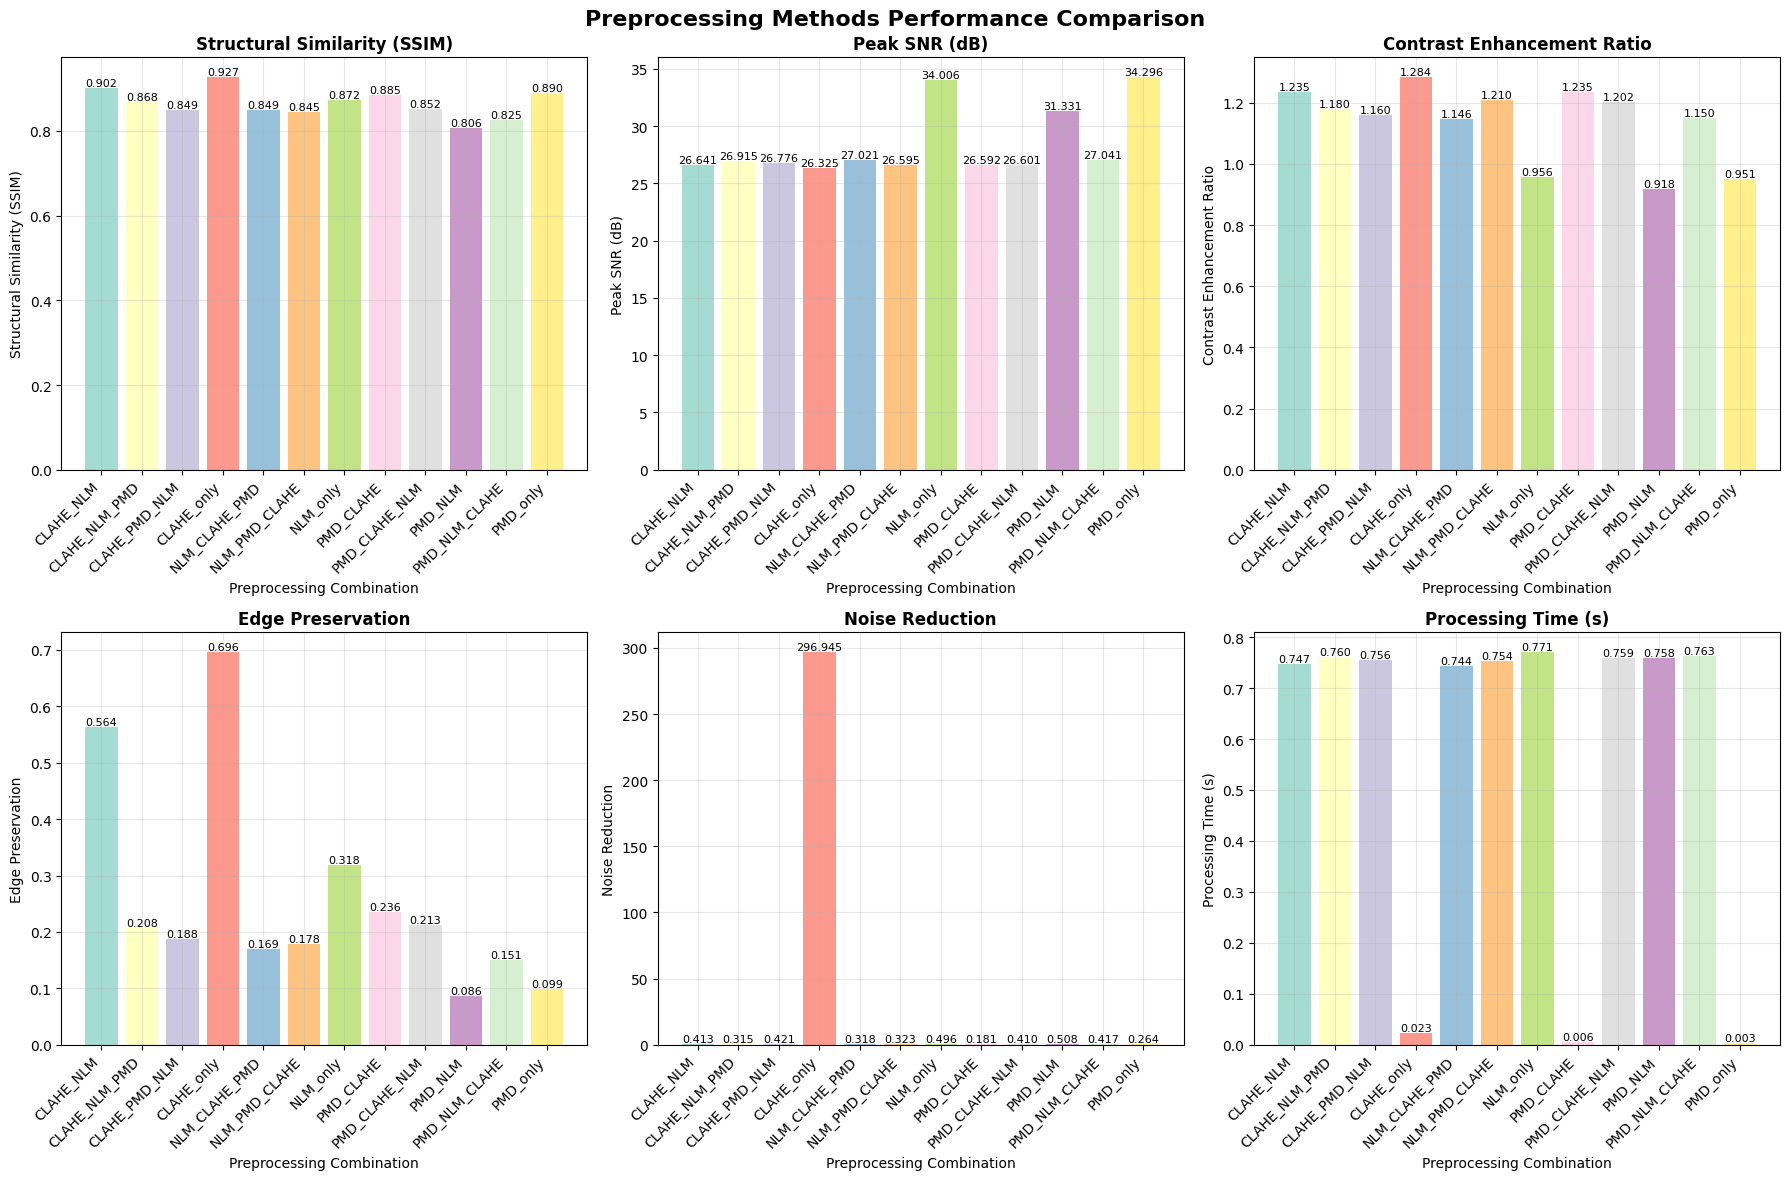

Performance comparison chart saved to: c:\Meet\Projects\Project_8_Phoenix_Cervical Cancer Image Classification\Project-Phoenix\Image Preprocessing\Comparative Analysis Results\preprocessing_performance_comparison.png


In [9]:
# Create comprehensive visualization of results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Preprocessing Methods Performance Comparison', fontsize=16, fontweight='bold')

# Metrics to visualize
metrics = ['SSIM', 'PSNR', 'Contrast_Enhancement', 'Edge_Preservation', 'Noise_Reduction', 'processing_time']
metric_titles = ['Structural Similarity (SSIM)', 'Peak SNR (dB)', 'Contrast Enhancement Ratio', 
                'Edge Preservation', 'Noise Reduction', 'Processing Time (s)']

for i, (metric, title) in enumerate(zip(metrics, metric_titles)):
    ax = axes[i//3, i%3]
    
    # Prepare data for plotting
    metric_data = combination_summary.reset_index()
    
    # Create bar plot
    bars = ax.bar(range(len(metric_data)), metric_data[metric], 
                  color=plt.cm.Set3(range(len(metric_data))), alpha=0.8)
    
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('Preprocessing Combination')
    ax.set_ylabel(title)
    
    # Rotate x-axis labels for better readability
    ax.set_xticks(range(len(metric_data)))
    ax.set_xticklabels(metric_data['combination'], rotation=45, ha='right')
    
    # Add value labels on bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "preprocessing_performance_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("Performance comparison chart saved to:", OUTPUT_DIR / "preprocessing_performance_comparison.png")

## Ranking Analysis - Find Best Combinations

In [10]:
# Create ranking analysis
def calculate_composite_score(row):
    """
    Calculate a composite score based on multiple metrics.
    Higher scores indicate better performance.
    """
    # Normalize and weight different metrics
    weights = {
        'SSIM': 0.25,           # Structural similarity (higher is better)
        'PSNR': 0.20,           # Signal quality (higher is better)
        'Contrast_Enhancement': 0.20,  # Contrast improvement (around 1.0-1.5 is optimal)
        'Edge_Preservation': 0.25,     # Edge preservation (higher is better)
        'Noise_Reduction': 0.10        # Noise reduction (positive values are better)
    }
    
    # Normalize SSIM (0-1 range, higher is better)
    ssim_score = row['SSIM']
    
    # Normalize PSNR (typically 20-40+ dB, higher is better)
    psnr_score = min(row['PSNR'] / 40.0, 1.0)  # Cap at 40 dB
    
    # Normalize Contrast Enhancement (optimal around 1.0-1.5)
    contrast_optimal = 1.25
    contrast_score = 1.0 - abs(row['Contrast_Enhancement'] - contrast_optimal) / contrast_optimal
    contrast_score = max(0, contrast_score)
    
    # Normalize Edge Preservation (-1 to 1 range, higher is better)
    edge_score = (row['Edge_Preservation'] + 1) / 2.0
    
    # Normalize Noise Reduction (-1 to 1 range, positive is better)
    noise_score = (row['Noise_Reduction'] + 1) / 2.0
    
    # Calculate composite score
    composite_score = (
        weights['SSIM'] * ssim_score +
        weights['PSNR'] * psnr_score +
        weights['Contrast_Enhancement'] * contrast_score +
        weights['Edge_Preservation'] * edge_score +
        weights['Noise_Reduction'] * noise_score
    )
    
    return composite_score

# Calculate composite scores
ranking_data = combination_summary.reset_index()
ranking_data['Composite_Score'] = ranking_data.apply(calculate_composite_score, axis=1)

# Sort by composite score
ranking_data = ranking_data.sort_values('Composite_Score', ascending=False)

print("\n" + "="*80)
print("PREPROCESSING COMBINATIONS RANKING")
print("="*80)
print("\nRanked by Composite Score (Higher is Better):")
print("-" * 80)

for i, row in ranking_data.iterrows():
    print(f"{ranking_data.index.get_loc(i) + 1:2d}. {row['combination']:<20} | Score: {row['Composite_Score']:.4f} | Methods: {row['methods']}")

# Display top 5 detailed metrics
print("\n" + "="*80)
print("TOP 5 COMBINATIONS - DETAILED METRICS")
print("="*80)

top_5 = ranking_data.head(5)
display_columns = ['combination', 'methods', 'Composite_Score', 'SSIM', 'PSNR', 
                  'Contrast_Enhancement', 'Edge_Preservation', 'Noise_Reduction', 'processing_time']
print(top_5[display_columns].to_string(index=False))

# Save ranking results
ranking_csv_path = OUTPUT_DIR / "preprocessing_combinations_ranking.csv"
ranking_data.to_csv(ranking_csv_path, index=False)
print(f"\nRanking results saved to: {ranking_csv_path}")


PREPROCESSING COMBINATIONS RANKING

Ranked by Composite Score (Higher is Better):
--------------------------------------------------------------------------------
 1. CLAHE_only           | Score: 15.6673 | Methods: CLAHE
 2. CLAHE_NLM            | Score: 0.8225 | Methods: CLAHE → NLM
 3. NLM_only             | Score: 0.7803 | Methods: NLM
 4. PMD_CLAHE            | Score: 0.7653 | Methods: PMD → CLAHE
 5. PMD_CLAHE_NLM        | Score: 0.7603 | Methods: PMD → CLAHE → NLM
 6. CLAHE_NLM_PMD        | Score: 0.7571 | Methods: CLAHE → NLM → PMD
 7. CLAHE_PMD_NLM        | Score: 0.7514 | Methods: CLAHE → PMD → NLM
 8. NLM_PMD_CLAHE        | Score: 0.7512 | Methods: NLM → PMD → CLAHE
 9. PMD_only             | Score: 0.7466 | Methods: PMD
10. NLM_CLAHE_PMD        | Score: 0.7427 | Methods: NLM → CLAHE → PMD
11. PMD_NLM_CLAHE        | Score: 0.7403 | Methods: PMD → NLM → CLAHE
12. PMD_NLM              | Score: 0.7161 | Methods: PMD → NLM

TOP 5 COMBINATIONS - DETAILED METRICS
  combination   

## Visual Comparison of Top Combinations


Creating visual comparison for top 3 combinations: ['CLAHE_only', 'CLAHE_NLM', 'NLM_only']


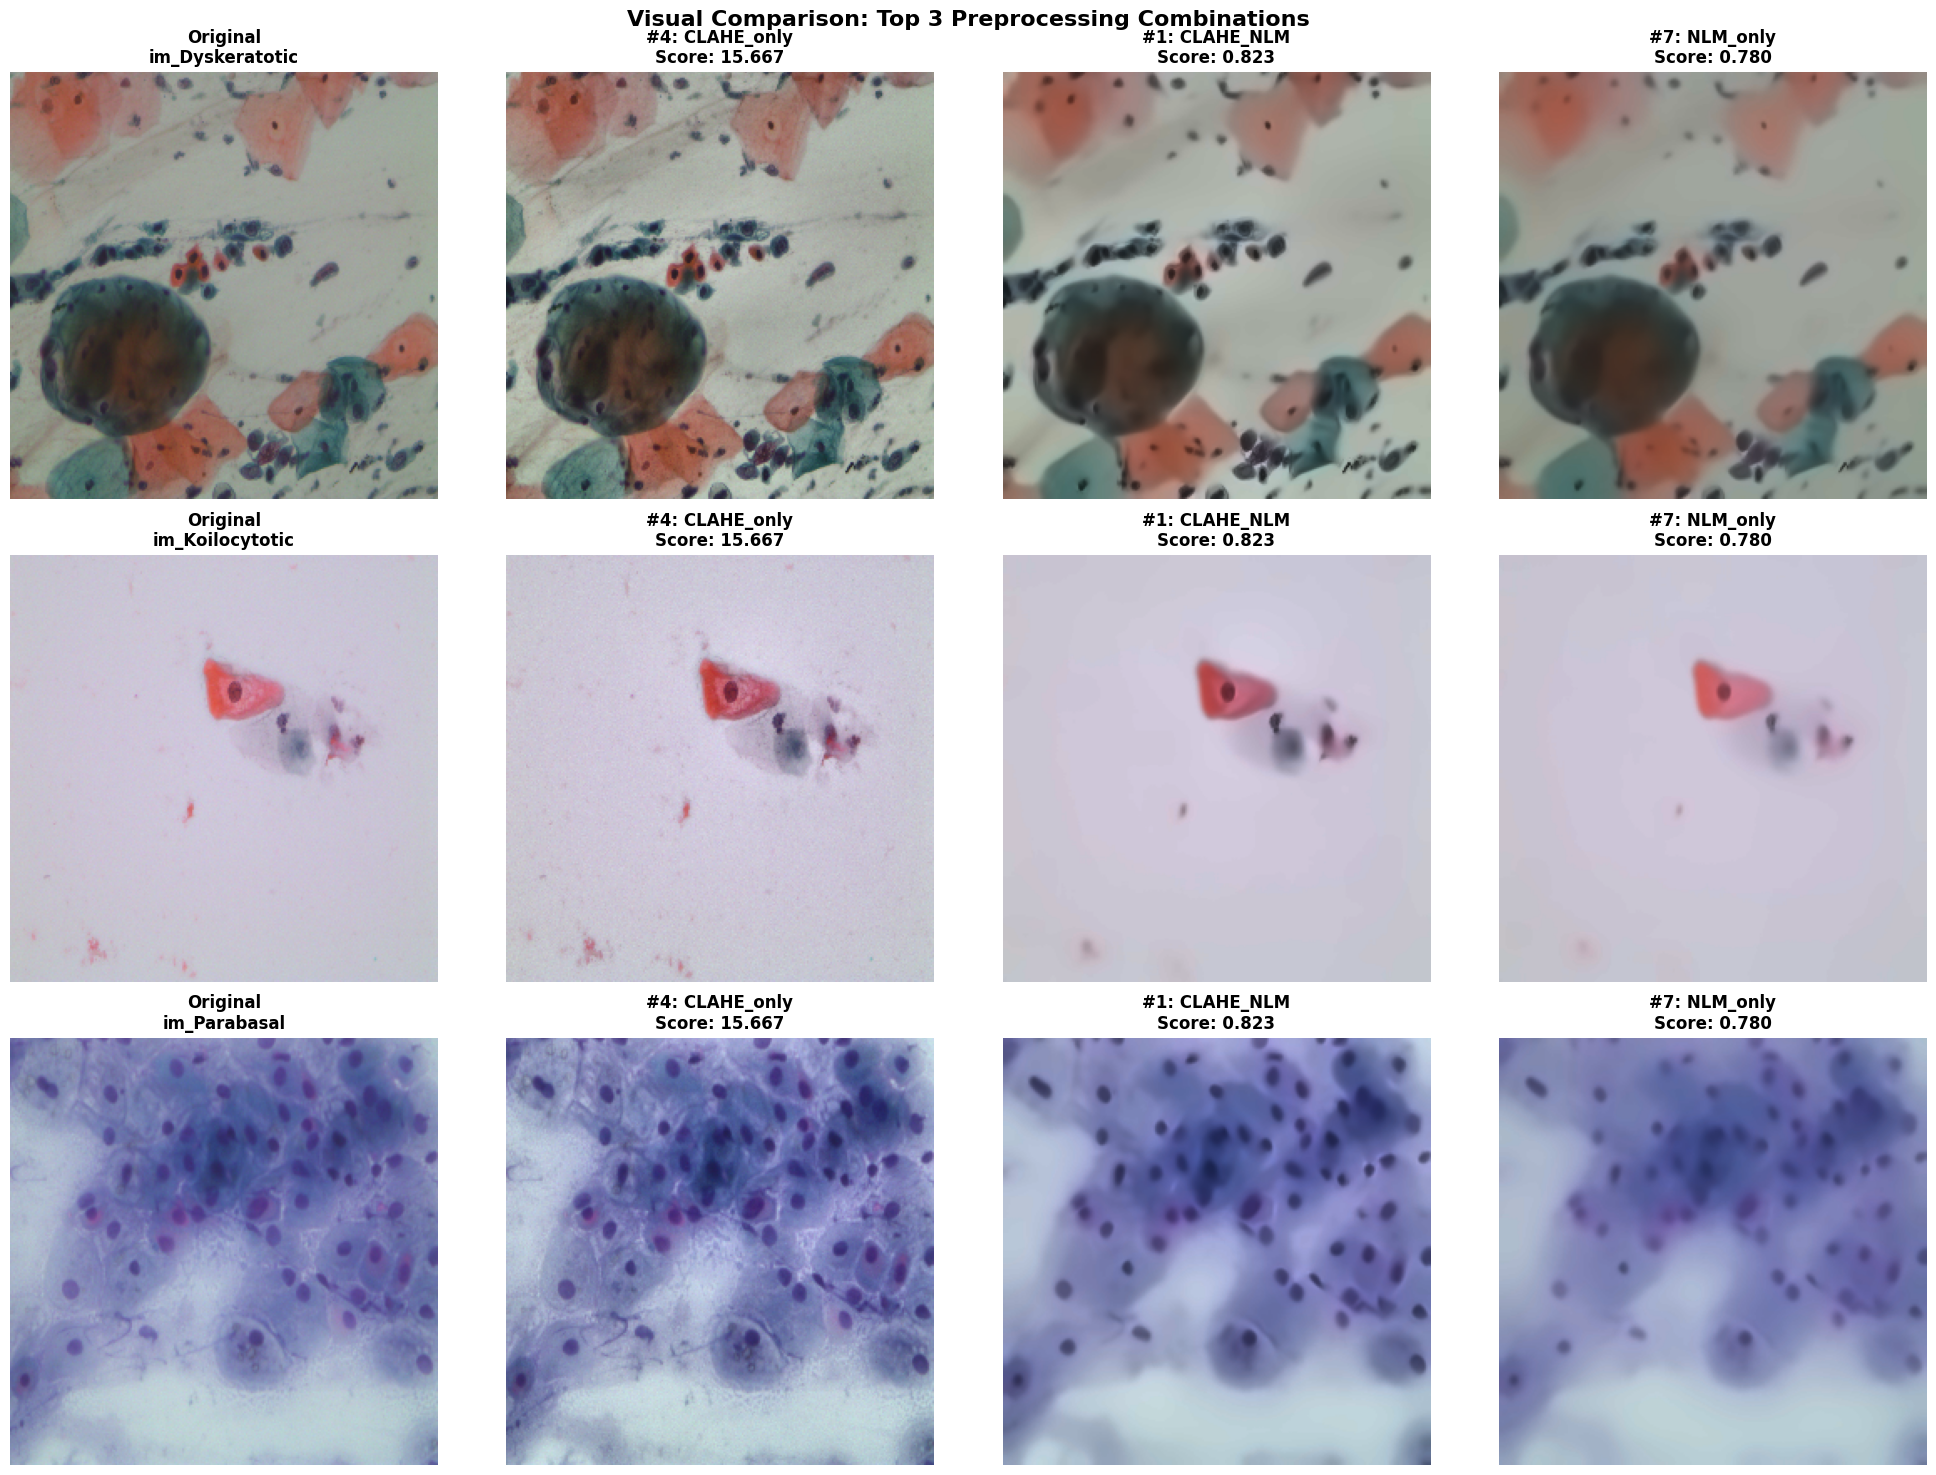

Visual comparison saved to: c:\Meet\Projects\Project_8_Phoenix_Cervical Cancer Image Classification\Project-Phoenix\Image Preprocessing\Comparative Analysis Results\top_3_combinations_visual_comparison.png


In [11]:
# Create visual comparison of top 3 combinations
top_3_combinations = ranking_data.head(3)['combination'].tolist()
print(f"\nCreating visual comparison for top 3 combinations: {top_3_combinations}")

# Select one representative image from each class for visualization
representative_classes = ['im_Dyskeratotic', 'im_Koilocytotic', 'im_Parabasal']  # 3 diverse classes

fig, axes = plt.subplots(len(representative_classes), len(top_3_combinations) + 1, 
                        figsize=(20, 15))
fig.suptitle('Visual Comparison: Top 3 Preprocessing Combinations', fontsize=16, fontweight='bold')

for class_idx, class_name in enumerate(representative_classes):
    if class_name not in processed_images_data[top_3_combinations[0]]:
        continue
        
    # Get the first image from this class
    original_image = processed_images_data[top_3_combinations[0]][class_name][0]['original']
    
    # Display original image
    ax = axes[class_idx, 0]
    ax.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    ax.set_title(f'Original\n{class_name}', fontweight='bold')
    ax.axis('off')
    
    # Display processed images for each top combination
    for combo_idx, combination in enumerate(top_3_combinations):
        processed_image = processed_images_data[combination][class_name][0]['processed']
        
        ax = axes[class_idx, combo_idx + 1]
        ax.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
        
        # Get rank and score for this combination
        rank = ranking_data[ranking_data['combination'] == combination].index[0] + 1
        score = ranking_data[ranking_data['combination'] == combination]['Composite_Score'].iloc[0]
        
        ax.set_title(f'#{rank}: {combination}\nScore: {score:.3f}', fontweight='bold')
        ax.axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "top_3_combinations_visual_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("Visual comparison saved to:", OUTPUT_DIR / "top_3_combinations_visual_comparison.png")

## Recommendations and Conclusions

In [12]:
# Generate detailed recommendations
print("\n" + "="*80)
print("COMPREHENSIVE ANALYSIS CONCLUSIONS & RECOMMENDATIONS")
print("="*80)

best_combination = ranking_data.iloc[0]
worst_combination = ranking_data.iloc[-1]

print(f"\n🏆 BEST PERFORMING COMBINATION:")
print(f"   Method: {best_combination['combination']}")
print(f"   Pipeline: {best_combination['methods']}")
print(f"   Composite Score: {best_combination['Composite_Score']:.4f}")
print(f"   SSIM: {best_combination['SSIM']:.4f}")
print(f"   PSNR: {best_combination['PSNR']:.2f} dB")
print(f"   Contrast Enhancement: {best_combination['Contrast_Enhancement']:.3f}")
print(f"   Edge Preservation: {best_combination['Edge_Preservation']:.4f}")
print(f"   Processing Time: {best_combination['processing_time']:.3f}s")

print(f"\n📊 ANALYSIS BY METHOD TYPE:")

# Single method analysis
single_methods = ranking_data[ranking_data['combination'].str.contains('only')]
print(f"\n   Single Methods Performance:")
for _, row in single_methods.iterrows():
    print(f"   - {row['combination']:<12}: Score {row['Composite_Score']:.4f}")

# Two method combinations
two_methods = ranking_data[ranking_data['methods'].str.count('→') == 0]
two_methods = two_methods[~two_methods['combination'].str.contains('only')]
two_methods = two_methods[two_methods['methods'].str.count(' ') == 2]  # Two methods separated by space
print(f"\n   Two-Method Combinations (Top 3):")
for _, row in two_methods.head(3).iterrows():
    print(f"   - {row['combination']:<15}: Score {row['Composite_Score']:.4f}")

# Three method combinations
three_methods = ranking_data[ranking_data['methods'].str.count('→') == 2]
print(f"\n   Three-Method Combinations (Top 3):")
for _, row in three_methods.head(3).iterrows():
    print(f"   - {row['combination']:<20}: Score {row['Composite_Score']:.4f}")

print(f"\n💡 KEY INSIGHTS:")

# Processing time analysis
fastest = ranking_data.loc[ranking_data['processing_time'].idxmin()]
slowest = ranking_data.loc[ranking_data['processing_time'].idxmax()]
print(f"   • Fastest method: {fastest['combination']} ({fastest['processing_time']:.3f}s)")
print(f"   • Slowest method: {slowest['combination']} ({slowest['processing_time']:.3f}s)")

# Best for specific metrics
best_ssim = ranking_data.loc[ranking_data['SSIM'].idxmax()]
best_contrast = ranking_data.loc[ranking_data['Contrast_Enhancement'].idxmax()]
best_edge = ranking_data.loc[ranking_data['Edge_Preservation'].idxmax()]

print(f"   • Best structural similarity: {best_ssim['combination']} (SSIM: {best_ssim['SSIM']:.4f})")
print(f"   • Best contrast enhancement: {best_contrast['combination']} (Ratio: {best_contrast['Contrast_Enhancement']:.3f})")
print(f"   • Best edge preservation: {best_edge['combination']} (Score: {best_edge['Edge_Preservation']:.4f})")

print(f"\n🎯 FINAL RECOMMENDATIONS:")
print(f"   1. For BEST OVERALL QUALITY: Use '{best_combination['combination']}'")
print(f"      Pipeline: {best_combination['methods']}")
print(f"\n   2. For FASTEST PROCESSING: Use '{fastest['combination']}'")
print(f"      Pipeline: {fastest['methods']}")
print(f"\n   3. For SPECIFIC NEEDS:")
print(f"      - Maximum contrast: '{best_contrast['combination']}'")
print(f"      - Best edge preservation: '{best_edge['combination']}'")
print(f"      - Structural similarity: '{best_ssim['combination']}'")

# Create summary report
summary_report = f"""
PREPROCESSING METHODS ANALYSIS SUMMARY REPORT
Generated on: {time.strftime('%Y-%m-%d %H:%M:%S')}

ANALYSIS SCOPE:
- Total combinations tested: {len(PREPROCESSING_COMBINATIONS)}
- Images per class: 2
- Cell classes analyzed: {len(CLASS_NAMES)}
- Total processing operations: {len(analysis_results)}

BEST PERFORMING COMBINATION:
Method: {best_combination['combination']}
Pipeline: {best_combination['methods']}
Composite Score: {best_combination['Composite_Score']:.4f}
SSIM: {best_combination['SSIM']:.4f}
PSNR: {best_combination['PSNR']:.2f} dB
Contrast Enhancement: {best_combination['Contrast_Enhancement']:.3f}
Edge Preservation: {best_combination['Edge_Preservation']:.4f}
Processing Time: {best_combination['processing_time']:.3f}s

RECOMMENDATION:
Based on the comprehensive analysis, the '{best_combination['combination']}' combination 
provides the best balance of image quality metrics for cervical cancer cell classification.
"""

# Save summary report
report_path = OUTPUT_DIR / "analysis_summary_report.txt"
with open(report_path, 'w') as f:
    f.write(summary_report)

print(f"\n📝 Complete analysis report saved to: {report_path}")
print(f"\n📁 All results saved in directory: {OUTPUT_DIR}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)


COMPREHENSIVE ANALYSIS CONCLUSIONS & RECOMMENDATIONS

🏆 BEST PERFORMING COMBINATION:
   Method: CLAHE_only
   Pipeline: CLAHE
   Composite Score: 15.6673
   SSIM: 0.9271
   PSNR: 26.33 dB
   Contrast Enhancement: 1.284
   Edge Preservation: 0.6963
   Processing Time: 0.023s

📊 ANALYSIS BY METHOD TYPE:

   Single Methods Performance:
   - CLAHE_only  : Score 15.6673
   - NLM_only    : Score 0.7803
   - PMD_only    : Score 0.7466

   Two-Method Combinations (Top 3):

   Three-Method Combinations (Top 3):
   - PMD_CLAHE_NLM       : Score 0.7603
   - CLAHE_NLM_PMD       : Score 0.7571
   - CLAHE_PMD_NLM       : Score 0.7514

💡 KEY INSIGHTS:
   • Fastest method: PMD_only (0.003s)
   • Slowest method: NLM_only (0.771s)
   • Best structural similarity: CLAHE_only (SSIM: 0.9271)
   • Best contrast enhancement: CLAHE_only (Ratio: 1.284)
   • Best edge preservation: CLAHE_only (Score: 0.6963)

🎯 FINAL RECOMMENDATIONS:
   1. For BEST OVERALL QUALITY: Use 'CLAHE_only'
      Pipeline: CLAHE

   2.